# Telecom Churn Classifying

The main objectives of the projects are consisted of two parts.

The first goal is to analyze the telecom customer data including their service usage, demographic and personal information in order to predict the churn rate.

The second goal is to figure out the variables that highly influenced the churn rate in the prediction model.

In [1]:
# added
# !pip install geopandas plotly graphviz pydotplus descartes statsmodels xgboost lime

In [2]:
# modules
import numpy as np
import pandas as pd
# Preprocessing
from IPython.display import Image  
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Visualization
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve
import graphviz
import pydotplus

# 1. Import data

In [3]:
df = pd.read_csv('cell2celltrain.csv')
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [4]:
df.shape

(51047, 58)

# 2. Preprocessing

## 2.1. Data frame 정리 (결측값, "Unknown")

In [5]:
print ('Missing values : \n',df.isnull().sum())

Missing values : 
 CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays    

In [6]:
# 결측값(NA) 있는 row 삭제 (1295개)
df = df.dropna()

In [7]:
# Unknown이 많은 columns -> 분석 반영 안해야하나?
# 혹은 Unknown이 있다는 것 자체가 소비자 데이터 조사에 성의 없이 임했다는 고객 정보를 반영했을 수도?
print(df.MaritalStatus.value_counts(), "\n\n", df.HandsetPrice.value_counts())
# df = df.drop(columns=['HandsetPrice', 'MaritalStatus'])

Unknown    18649
Yes        18506
No         12597
Name: MaritalStatus, dtype: int64 

 Unknown    28263
30          7147
150         4024
130         2043
80          1901
10          1869
60          1730
200         1227
100         1209
40           240
400           45
250           20
300           12
180            9
500            7
240            6
Name: HandsetPrice, dtype: int64


In [8]:
df.describe()

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,4.975200e+04,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,...,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000
mean,3.200958e+06,58.717374,525.021466,46.834961,0.891841,39.754040,1.226327,-11.656175,-1.175937,6.010556,...,1.805093,1.558711,380.020843,31.338258,21.147592,0.035496,0.018331,0.051475,4.402677,0.053686
std,1.164694e+05,44.317244,528.510155,23.759492,2.224725,96.091606,9.848360,255.858193,39.392124,9.036653,...,1.330834,0.906256,252.290072,22.091593,23.926589,0.201964,0.142854,0.266490,3.110498,0.382677
min,3.000002e+06,-6.170000,0.000000,-6.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,...,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100094e+06,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.000000,0.700000,...,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.200144e+06,48.380000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,...,1.000000,1.000000,330.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.303643e+06,70.910000,722.000000,60.000000,0.990000,40.000000,0.300000,65.000000,1.600000,7.700000,...,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399974e+06,1223.380000,7359.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,...,24.000000,15.000000,1812.000000,99.000000,99.000000,4.000000,3.000000,16.000000,9.000000,25.000000


# 3. Define Variables

In [9]:
df.info()
df['IncomeGroup'] = df['IncomeGroup'].astype(object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49752 entries, 0 to 51043
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 49752 non-null  int64  
 1   Churn                      49752 non-null  object 
 2   MonthlyRevenue             49752 non-null  float64
 3   MonthlyMinutes             49752 non-null  float64
 4   TotalRecurringCharge       49752 non-null  float64
 5   DirectorAssistedCalls      49752 non-null  float64
 6   OverageMinutes             49752 non-null  float64
 7   RoamingCalls               49752 non-null  float64
 8   PercChangeMinutes          49752 non-null  float64
 9   PercChangeRevenues         49752 non-null  float64
 10  DroppedCalls               49752 non-null  float64
 11  BlockedCalls               49752 non-null  float64
 12  UnansweredCalls            49752 non-null  float64
 13  CustomerCareCalls          49752 non-null  flo

## 3.1. Label Encoding  

In [10]:
# Variables are edited in df2
df2 = df
df2['Churn'] = df2['Churn'].replace({"Yes" : 1, "No" : 0})

In [11]:
df2['Churn'].describe()

count    49752.000000
mean         0.286320
std          0.452045
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Churn, dtype: float64

## 3.2. Feature Manipulation

### 3.2.1. Age

In [12]:
# AgeHH1, AgeHH2 variable 하나로 정리 (제 1 이용자, 제 2 이용자) -> Multicollinearity 문제
# column 내 결측값(0)이 전체 row의 1/4 이상이라 결측시에는 median으로 대체
# 
medianage = np.median(df2['AgeHH1'])
print("Median Age = ", medianage)

conditions = [
    (df2['AgeHH1'] == 0) & (df2['AgeHH2'] == 0),
    (df2['AgeHH1'] > 0) & (df2['AgeHH2'] == 0),
    (df2['AgeHH1'] > 0) & (df2['AgeHH2'])]
choices = [medianage, df2['AgeHH1'], (df2['AgeHH1'] + df2['AgeHH2']) / 2]

df2['Age'] = np.select(conditions, choices, default= (df2['AgeHH1'] + df2['AgeHH2']) / 2)

Median Age =  36.0


### 3.2.2. Subs

In [13]:
# ActiveSubs & UniqueSubs (Account 내 등록 인원 변수)
df2['SubsRatio'] = df2['ActiveSubs'] / df2['UniqueSubs']

### 3.2.3. Service Area

In [14]:
# Service Area variable -> Category variable. But too many unique values inside.
# Redefine for better interpretability
df['ServiceArea'].head(15)

0     SEAPOR503
1     PITHOM412
2     MILMIL414
3     PITHOM412
4     OKCTUL918
5     OKCTUL918
6     OKCTUL918
7     OKCOKC405
8     SANMCA210
9     PITHOM412
10    SANMCA210
11    SLCSLC801
12    OKCOKC405
13    SLCSLC801
14    MILMIL414
Name: ServiceArea, dtype: object

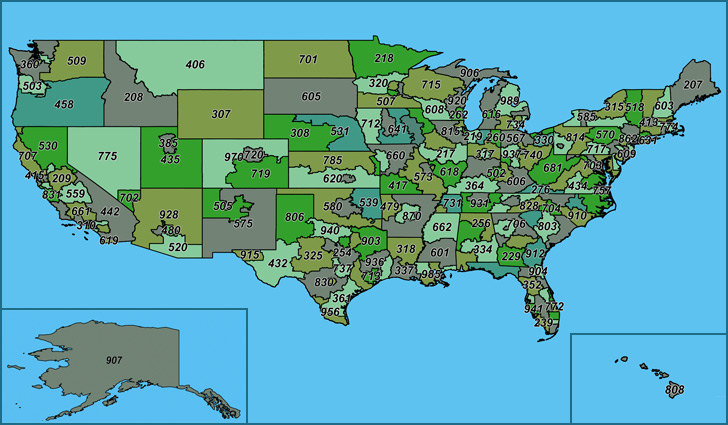

In [15]:
# ServiceArea = USA telephone number area code
Image('united-states-area-code-map.jpg') 

In [16]:
df2['ServiceAreaNo'] = df2['ServiceArea'].str.slice(start=6).astype(object)

In [17]:
shp_path = "./AreaCode/AreaCode2.shp"
shp = gpd.read_file(shp_path)
shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    264 non-null    object  
 1   NPA         283 non-null    object  
 2   STATE       283 non-null    object  
 3   TYPE        193 non-null    object  
 4   BEGINDIAL   4 non-null      object  
 5   PREVNPA     194 non-null    object  
 6   ENDDIAL     147 non-null    object  
 7   COUNTRY     283 non-null    object  
 8   TGS_ADDED   283 non-null    object  
 9   TGS_MOD     283 non-null    object  
 10  Shape_Leng  283 non-null    float64 
 11  Shape_Area  283 non-null    float64 
 12  geometry    283 non-null    geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 28.9+ KB


In [18]:
# Mean churn ratio by areas
geo = df2.groupby('ServiceAreaNo').mean()['Churn']
geo.describe()

count    195.000000
mean       0.288930
std        0.079769
min        0.000000
25%        0.260950
50%        0.290323
75%        0.320437
max        0.500000
Name: Churn, dtype: float64

In [19]:
# Merge data with the map
merged = pd.merge(shp, geo, left_on='NPA', right_index=True, how='left')
merged = merged.fillna(merged.median())

<AxesSubplot:>

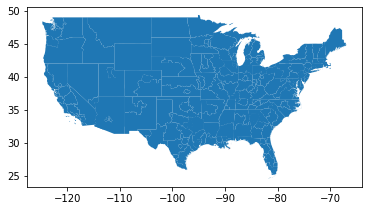

In [20]:
merged.plot()

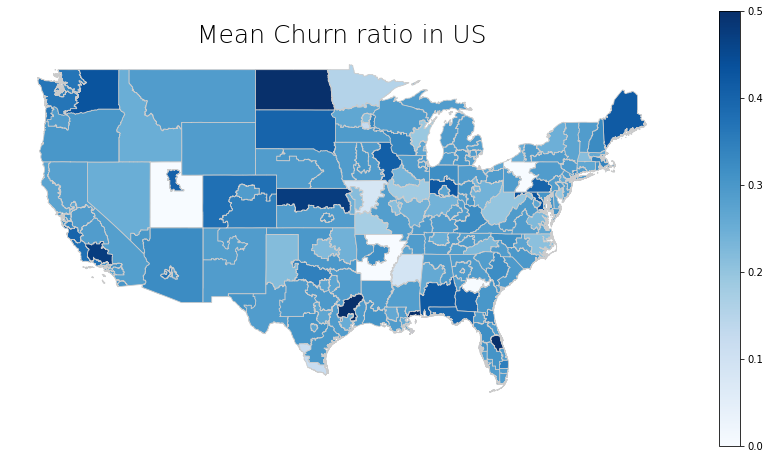

In [21]:
fig, ax = plt.subplots(1, figsize=(15, 8))
merged.plot(column='Churn', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Mean Churn ratio in US', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(merged['Churn']), vmax=max(merged['Churn'])))
sm._A = []
impocbar = fig.colorbar(sm)

In [22]:
# Region classification -> group
states = pd.read_csv('state_code.csv')
states['ServiceAreaNo'] = states['ServiceAreaNo'].astype(str)
#states = (states.set_index(['Code', 'division']).stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index())
states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   StateCode      241 non-null    object
 1   Division       241 non-null    object
 2   ServiceAreaNo  241 non-null    object
dtypes: object(3)
memory usage: 5.8+ KB


In [23]:
df2 = pd.merge(df2, states, on = 'ServiceAreaNo')
df2['Division'].value_counts()

south        17841
west         10652
midwest       9836
northeast     6722
Name: Division, dtype: int64

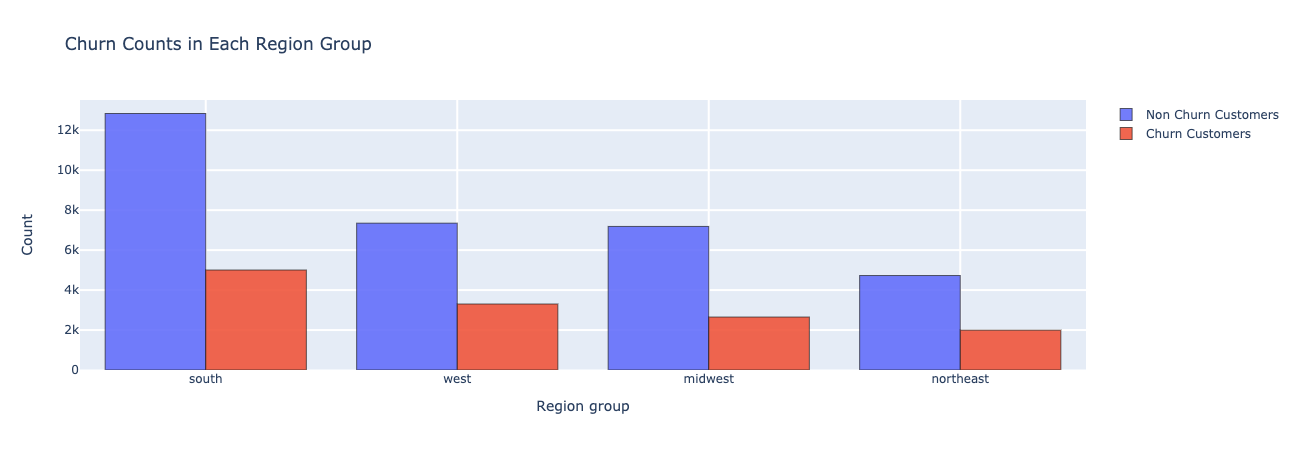

In [24]:
# Is division variable significant?

churn = df2[df2['Churn'] == 1]
nochurn = df2[df2['Churn'] == 0]

div_ch  =  churn['Division'].value_counts().reset_index()
div_ch.columns  = ['Division',"count"]
div_nch  =  nochurn['Division'].value_counts().reset_index()
div_nch.columns  = ['Division',"count"]

trace1 = go.Bar(x = div_nch['Division']  , y = div_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)
trace2 = go.Bar(x = div_ch['Division'] , y = div_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Churn Counts in Each Region Group",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Region group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1, trace2]
fig  = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [25]:
# ANOVA to figure out if the variable is statistically significant or not


import scipy.stats as stats

west = df2[df2['Division'] == 'west']['Churn']
northeast = df2[df2['Division'] == 'northeast']['Churn']
south = df2[df2['Division'] == 'south']['Churn']
midwest = df2[df2['Division'] == 'midwest']['Churn']

F_statistic, pVal = stats.f_oneway(west, northeast, south, midwest)
print('ANOVA 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
if pVal < 0.05:
    print('지역 그룹별 평균값이 통계적으로 유의미하게 차이난다.')

ANOVA 결과 : F=16.4, p=0.00000
지역 그룹별 평균값이 통계적으로 유의미하게 차이난다.


## 3.3. Feature Encoding

### 3.3.1. Binary Features

In [26]:
# Encoding binary variables
binary_cols = ['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'BuysViaMailOrder', 
               'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 
               'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam']
for i in binary_cols :
    df2[i] = df2[i].replace({'Yes' : 1, 'No' : 0})

df2['Homeownership'] = df2['Homeownership'].replace({"Known" : 1, "Unknown" : 0})

### 3.3.2. Categorical Features

In [27]:
# and categorical variables as well
cat_cols = ['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus', 'Division']

df2 = pd.get_dummies(df2,columns=cat_cols, drop_first=False)

#for i in cat_cols:
#    df[i] = ohe.fit_transform(df[i]).toarray()

In [28]:
# One hot encoded variables
df2.iloc[:, 58:].head()

,CreditRating_1-Highest,CreditRating_2-High,CreditRating_3-Good,CreditRating_4-Medium,CreditRating_5-Low,CreditRating_6-VeryLow,CreditRating_7-Lowest,PrizmCode_Other,PrizmCode_Rural,PrizmCode_Suburban,...,Occupation_Retired,Occupation_Self,Occupation_Student,MaritalStatus_No,MaritalStatus_Unknown,MaritalStatus_Yes,Division_midwest,Division_northeast,Division_south,Division_west
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


### 3.3.3. Numerical Features

In [29]:
# Scaling numerical variables (mean = 0, variance = 1)

num_cols = ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
            'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls',
            'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
            'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs',
            'SubsRatio', 'Handsets', 'CurrentEquipmentDays']

scaler = StandardScaler()
df2[num_cols] = scaler.fit_transform(df2[num_cols])

In [30]:
df2.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,Occupation_Retired,Occupation_Self,Occupation_Student,MaritalStatus_No,MaritalStatus_Unknown,MaritalStatus_Yes,Division_midwest,Division_northeast,Division_south,Division_west
0,3000002,1,-0.789960,-0.566633,-1.035108,-0.291000,-0.408093,-0.177150,-0.578586,-0.484977,...,0,0,0,1,0,0,0,0,0,1
1,3000982,0,-0.104585,-0.709608,0.137978,-0.401521,-0.408093,-0.177150,0.333432,0.020479,...,0,0,0,0,1,0,0,0,0,1
2,3001426,0,0.372799,0.131083,1.436752,0.036142,-0.408093,-0.177150,0.353345,-0.914342,...,0,0,0,1,0,0,0,0,0,1
3,3001454,0,0.849029,2.050757,1.185376,4.412774,-0.335432,-0.177150,0.883032,0.023197,...,0,0,0,0,1,0,0,0,0,1
4,3002070,0,0.603412,1.435012,1.185376,0.473806,-0.408093,0.697522,-0.367507,-0.055611,...,0,0,0,0,0,1,0,0,0,1


# 4. Exploratory Data Analysis

## 4.1. Label (Churn)

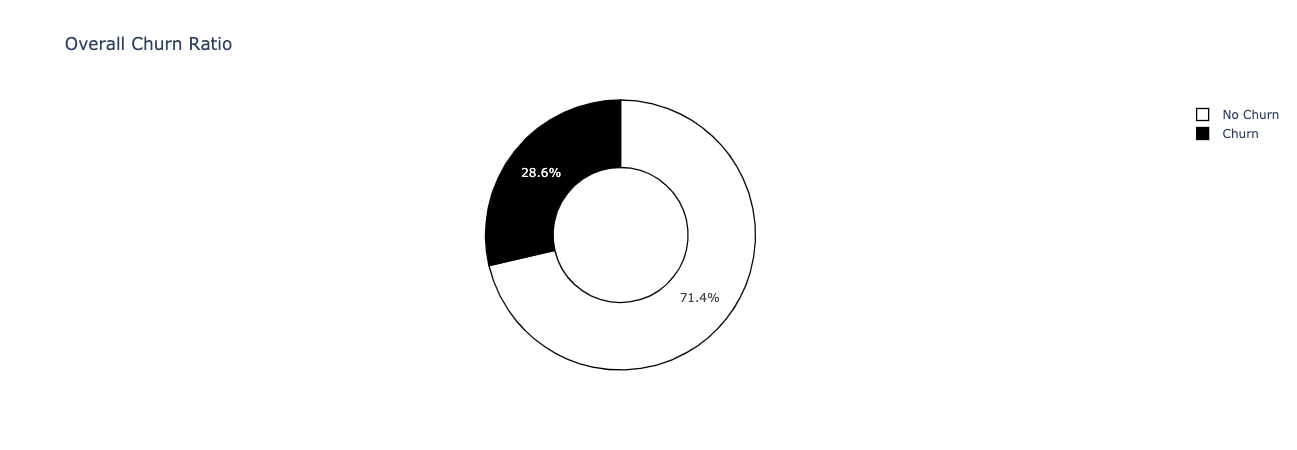

In [31]:
ch_val = df['Churn'].value_counts().values.tolist()

trace = go.Pie(labels = ['No Churn', 'Churn'],
               values = ch_val,
               marker = dict(colors =  ['white','black'],
                             line = dict(color = 'black',
                                         width =  1.3)),
               hole = .5
              )
layout = go.Layout(dict(title = 'Overall Churn Ratio'))

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

## 4.2. Correlation Matrix

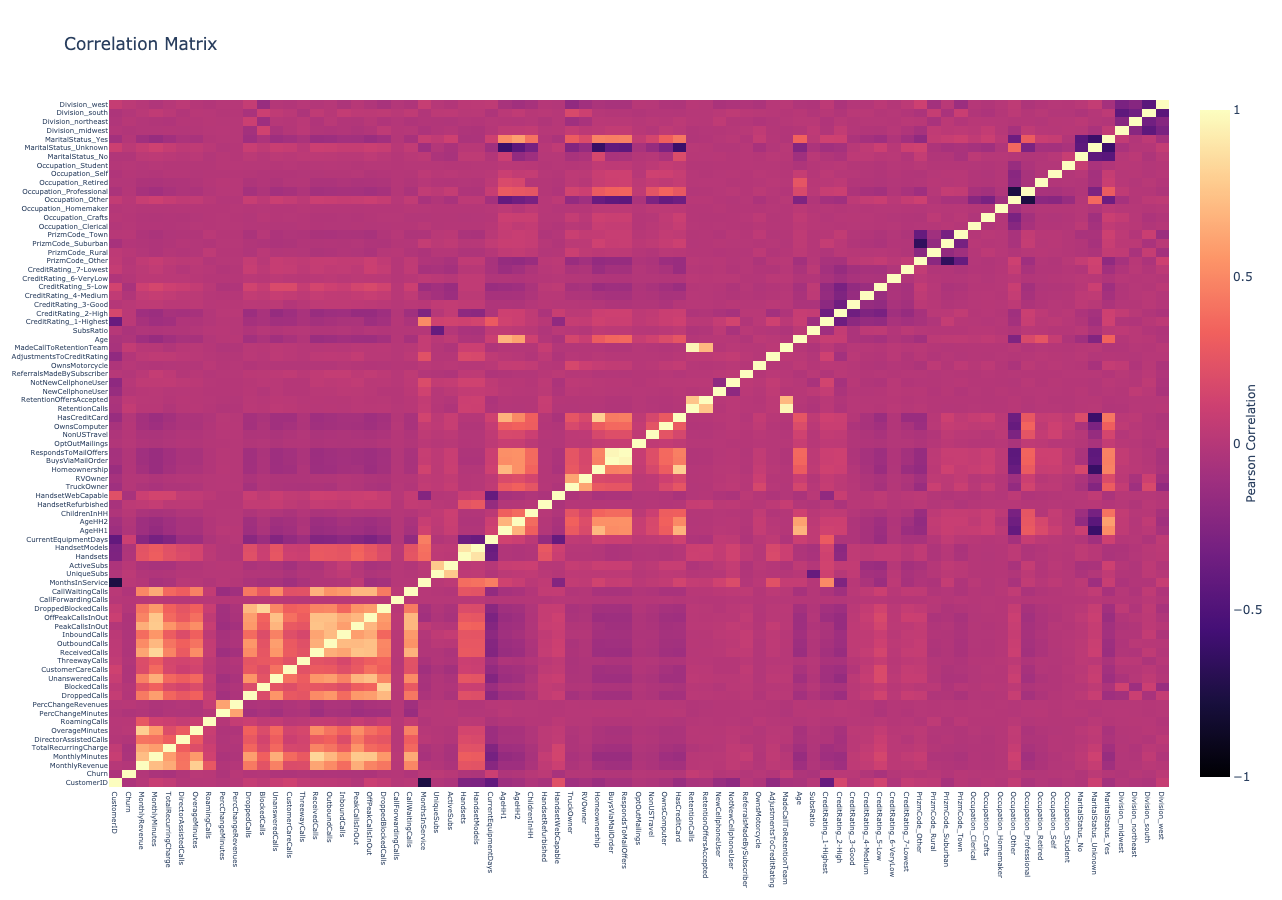

In [32]:
correlation = df2.corr()
corr_cols = correlation.columns.tolist()

trace = go.Heatmap(z = np.array(correlation),
                   x = corr_cols,
                   y = corr_cols,
                   colorscale = 'magma',
                   colorbar   = dict(title = 'Pearson Correlation',
                                     titleside = 'right'
                                    ) ,
                   zmin = -1,
                   zmax = 1
                  )
layout = go.Layout(dict(title = 'Correlation Matrix',
                        autosize = False ,
                        height = 900,
                        width = 900,
                        yaxis   = dict(tickfont = dict(size = 7)),
                        xaxis   = dict(tickfont = dict(size = 7))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [33]:
## 4.3. Some of the Categorical Variables

# 5. VIF

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(
    df2[num_cols].values, i) for i in range(df2[num_cols].shape[1])]
vif['features'] = df2[num_cols].columns
print(vif)

    VIF Factor               features
0    11.180975         MonthlyRevenue
1     6.210495         MonthlyMinutes
2     4.250156   TotalRecurringCharge
3     1.357299  DirectorAssistedCalls
4     6.714633         OverageMinutes
5     1.313211           RoamingCalls
6     1.631839      PercChangeMinutes
7     1.606149     PercChangeRevenues
8    86.710766           DroppedCalls
9   140.064766           BlockedCalls
10    2.846329        UnansweredCalls
11    1.338211      CustomerCareCalls
12    1.187246          ThreewayCalls
13    4.276913          ReceivedCalls
14    3.505469          OutboundCalls
15    2.477009           InboundCalls
16    4.677214         PeakCallsInOut
17    5.280620      OffPeakCallsInOut
18  266.968272    DroppedBlockedCalls
19    1.001545    CallForwardingCalls
20    2.777982       CallWaitingCalls
21    2.318156        MonthsInService
22    1.195600             UniqueSubs
23    1.186254              SubsRatio
24    2.181294               Handsets
25    2.2214

## 5.1. Redefine Features

In [35]:
# Correlated variables are excluded to prevent multicollinearity since it can affect the results of the Feature Importance.
# Many of the numerical variables are correlated to each other, and Judging by the correlation and VIF, 
# MonthlyMinutes, PercChangeMinutes, DroppedCalls, BlockedCalls, ReceivedCalls, OffPeakCallsInOut, DroppedBlockedCalls variables
# are excluded in the modeling process.

In [36]:
label = df2['Churn']
featurenames = ['MonthlyRevenue', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
            'RoamingCalls', 'PercChangeRevenues', 'UnansweredCalls',
            'CustomerCareCalls', 'ThreewayCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
            'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs',
            'SubsRatio', 'Handsets', 'CurrentEquipmentDays', 'ChildrenInHH', 'HandsetRefurbished', 
            'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'BuysViaMailOrder', 
            'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 
            'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam',
            'CreditRating_1-Highest', 'CreditRating_2-High', 'CreditRating_3-Good', 'CreditRating_4-Medium', 'CreditRating_5-Low', 
            'CreditRating_6-VeryLow', 'CreditRating_7-Lowest', 'PrizmCode_Other', 'PrizmCode_Rural', 'PrizmCode_Suburban', 'PrizmCode_Town',
            'Occupation_Clerical', 'Occupation_Crafts', 'Occupation_Homemaker', 'Occupation_Other', 'Occupation_Professional', 'Occupation_Retired',
            'Occupation_Self', 'Occupation_Student', 'MaritalStatus_No', 'MaritalStatus_Unknown', 'MaritalStatus_Yes', 
            'Division_midwest', 'Division_northeast', 'Division_south', 'Division_west']
features = df2[featurenames]

In [37]:
features.head()

,MonthlyRevenue,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeRevenues,UnansweredCalls,CustomerCareCalls,ThreewayCalls,OutboundCalls,...,Occupation_Retired,Occupation_Self,Occupation_Student,MaritalStatus_No,MaritalStatus_Unknown,MaritalStatus_Yes,Division_midwest,Division_northeast,Division_south,Division_west
0,-0.789960,-1.035108,-0.291000,-0.408093,-0.177150,-0.484977,-0.566817,-0.361195,-0.249311,-0.719595,...,0,0,0,1,0,0,0,0,0,1
1,-0.104585,0.137978,-0.401521,-0.408093,-0.177150,0.020479,-0.574650,-0.300727,-0.249311,-0.491823,...,0,0,0,0,1,0,0,0,0,1
2,0.372799,1.436752,0.036142,-0.408093,-0.177150,-0.914342,-0.130781,-0.300727,-0.249311,-0.166434,...,0,0,0,1,0,0,0,0,0,1
3,0.849029,1.185376,4.412774,-0.335432,-0.177150,0.023197,1.827468,0.384575,0.009974,3.472002,...,0,0,0,0,1,0,0,0,0,1
4,0.603412,1.185376,0.473806,-0.408093,0.697522,-0.055611,0.164262,-0.361195,0.614971,0.759444,...,0,0,0,0,0,1,0,0,0,1


# 6. Modeling

In [38]:
train_x, test_x, train_y, test_y = train_test_split(features, label, random_state = 0) #default train size = 0.25

In [39]:
# report for model evaluation
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, precision_recall_fscore_support

def model_report(model):
    pred_y = model.predict(test_x)
    cm = confusion_matrix(test_y, pred_y)
    # AUC - ROC curve
    y_score = model.predict_proba(test_x)[:,1]
    fpr,tpr,thresholds = roc_curve(test_y,y_score)
    model_roc_auc = roc_auc_score(test_y,pred_y)
    model_f1_score_macro = precision_recall_fscore_support(test_y, pred_y, average="macro")[2]
    model_f1_score_weighted = precision_recall_fscore_support(test_y, pred_y, average="weighted")[2]
    print("Confusion Matrix\n", cm, "\n")
    print(classification_report(test_y, pred_y, target_names=['No Churn', 'Churn']))
    print("Accuracy Score      : ",accuracy_score(test_y, pred_y).round(4))
    print("Area Under Curve    : ",model_roc_auc.round(4))
    print("F1 Score (macro)    : ", model_f1_score_macro.round(4))
    print("F1 Score (weighted) : ", model_f1_score_weighted.round(4), "\n")
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## 6.1. Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

logreg = LogisticRegression(C=1.0, class_weight=None, fit_intercept=True, solver='liblinear', max_iter=1000).fit(train_x, train_y)

print("Logistic Regression Score \n{:.4f}".format(logreg.score(test_x, test_y)))

Logistic Regression Score 
0.7114


Confusion Matrix
 [[7943  102]
 [3149   69]] 

              precision    recall  f1-score   support

    No Churn       0.72      0.99      0.83      8045
       Churn       0.40      0.02      0.04      3218

    accuracy                           0.71     11263
   macro avg       0.56      0.50      0.44     11263
weighted avg       0.63      0.71      0.60     11263

Accuracy Score      :  0.7114
Area Under Curve    :  0.5044
F1 Score (macro)    :  0.4354
F1 Score (weighted) :  0.6046 



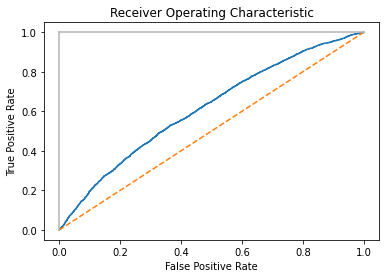

In [41]:
model_report(logreg)

## 6.2. SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma='auto', probability=True).fit(train_x, train_y)

print('SVM Accuracy Score \n{:.4f}'.format(svm.score(test_x, test_y)))

In [ ]:
model_report(svm)

## 6.3. Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=0).fit(train_x, train_y)

print('Decision Tree Accuracy Score \n{:.4f}'.format(tree.score(test_x, test_y)))

In [ ]:
model_report(tree)

## 6.4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

ranfo = RandomForestClassifier(n_estimators=1000, random_state=0).fit(train_x, train_y)

print("Random Forest Accuracy Score \n{:.4f}".format(ranfo.score(test_x, test_y)))

In [ ]:
model_report(ranfo)

## 6.5. Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0).fit(train_x, train_y)

print("Gradient Boosting Classifier Accuracy Score \n{:.4f}".format(gbc.score(test_x, test_y)))

In [ ]:
model_report(gbc)

## 6.6. XGBoost

In [ ]:
# XGBoost modeling
from xgboost import XGBClassifier, plot_importance

xgb = XGBClassifier().fit(train_x, train_y)

print("XBBoost Classifier Accuracy Score \n{:.4f}".format(xgb.score(test_x, test_y)))

In [ ]:
# Parameter Tuning
from sklearn.model_selection import GridSearchCV

grid_params = [
    {
        "max_depth": [4, 6, 8],
        "learning_rate": [0.001, 0.1, 1],
        "n_estimators": [10, 100, 300]
    }
]

xgb_cv = GridSearchCV(XGBClassifier(), grid_params, cv=5, return_train_score=True).fit(train_x, train_y)

print("Best parameter values: {}\n".format(xgb_cv.best_params_))

In [ ]:
xgb_2 = xgb_cv.best_estimator_.fit(train_x, train_y)

In [ ]:
cvresults = pd.DataFrame(xgb_cv.cv_results_)
display(cvresults.T)

In [ ]:
model_report(xgb_2)

# 7. Which feature has been important in the model?

## 7.1. Feature Importance Plot for XGBoost model

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 8))

plot_importance(xgb_2, ax=ax)

## 7.2. LIME

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# fit the best model again with the data transformed from dataframe to array for lime
train_xv = train_x.to_numpy()
test_xv = test_x.to_numpy()

xgb_l = xgb_cv.best_estimator_.fit(train_xv, train_y)


In [ ]:
# Explaining a random instance
explainer = lime.lime_tabular.LimeTabularExplainer(train_xv, mode='classification', feature_names=featurenames,
                                                   class_names=["No Churn", "Churn"])

i = np.random.randint(0, test_y.shape[0])

predict_fn = lambda x: xgb_l.predict_proba(x).astype(float)
exp = explainer.explain_instance(test_xv[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)

In [ ]:
# Churn case
i = 579
exp = explainer.explain_instance(test_xv[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)

In [ ]:
# No Churn case
i = 111
exp = explainer.explain_instance(test_xv[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)

# 8. Feature Selection and Re-training

In [ ]:
# Feature Selection using the feature importance above
# select features using threshold
featureimp = xgb_2.get_booster().get_fscore()
featureimp

In [ ]:
from sklearn.feature_selection import SelectFromModel
thresholds = sorted(xgb_2.feature_importances_)
b = np.empty((0, 3))

for a in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_2, threshold=a, prefit=True)
    select_train_x = selection.transform(train_x)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_train_x, train_y)
    # eval model
    select_test_x = selection.transform(test_x)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = accuracy_score(test_y, predictions)
    b = np.append(b, np.array([[a, select_train_x.shape[1], accuracy]]), axis=0)
    print("Threshold=%.3f, n=%d, Accuracy: %.2f%%" % (a, select_train_x.shape[1], accuracy*100.0))

In [ ]:
selection = SelectFromModel(xgb_2, threshold=0.036, prefit=True)
select_train_x = selection.transform(train_x)
select_test_x = selection.transform(test_x)

In [ ]:
grid_params = [
    {
        "max_depth": [4, 6, 8],
        "learning_rate": [0.001, 0.1, 1],
        "n_estimators": [10, 100, 300]
    }
]

xgb_cv3 = GridSearchCV(xgb_2, grid_params, cv=5, return_train_score=True).fit(select_train_x, train_y)

print("Best parameter values: {}\n".format(xgb_cv3.best_params_))

print("XGBoost Classifier Grid Search Best Accuracy Score \n{:.4f}".format(xgb_cv3.best_score_))

In [ ]:
cvresults3 = pd.DataFrame(xgb_cv3.cv_results_)
display(cvresults3.T)

In [ ]:
# model report
pred_y = xgb_cv3.best_estimator_.predict(select_test_x)
cm = confusion_matrix(test_y, pred_y)
# AUC - ROC curve
y_score = xgb_cv3.best_estimator_.predict_proba(select_test_x)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,y_score)
model_roc_auc = roc_auc_score(test_y,pred_y)
model_f1_score_macro = precision_recall_fscore_support(test_y, pred_y, average="macro")[2]
model_f1_score_weighted = precision_recall_fscore_support(test_y, pred_y, average="weighted")[2]
print("Confusion Matrix\n", cm, "\n")
print(classification_report(test_y, pred_y, target_names=['No Churn', 'Churn']))
print("Accuracy Score      : ",accuracy_score(test_y, pred_y).round(4))
print("Area under curve    : ",model_roc_auc.round(4))
print("F1 Score (macro)    : ", model_f1_score_macro.round(4))
print("F1 Score (weighted) : ", model_f1_score_weighted.round(4), "\n")
    
    
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 8.1. Dealing with the Threshold

(Maximized Recall)

In [ ]:
y_pred = xgb_2.predict_proba(test_x)
precision, recall, thresholds = precision_recall_curve(test_y, y_pred[:,1])
 
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

In [ ]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

In [ ]:
threshold = scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0]

y_pred = xgb_2.predict(test_x)
y_pred_proba = xgb_2.predict_proba(test_x)
y_proba = y_pred_proba[:,1].tolist()

final_y = []
for a in y_proba:
    if a > threshold:
        final_y.append(1)
    else:
        final_y.append(0)
        
print(final_y.count(1), final_y.count(0))

In [ ]:
cm = confusion_matrix(test_y, final_y)
fpr,tpr,thresholds = roc_curve(test_y,y_score)
model_f1_score_macro = precision_recall_fscore_support(test_y, final_y, average="macro")[2]
model_f1_score_weighted = precision_recall_fscore_support(test_y, final_y, average="weighted")[2]


print("Confusion Matrix\n", cm, "\n")
print(classification_report(test_y, final_y, target_names=['No Churn', 'Churn']))
print("Accuracy Score      : ",accuracy_score(test_y, final_y).round(4))
print("Area under curve    : ",model_roc_auc.round(4))
print("F1 Score (macro)    : ", model_f1_score_macro.round(4))
print("F1 Score (weighted) : ", model_f1_score_weighted.round(4), "\n")